<a href="https://colab.research.google.com/github/rastringer/unraveling_superposition/blob/main/language_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Superposition in language models

In [ ]:
!pip install transformers datasets torchviz

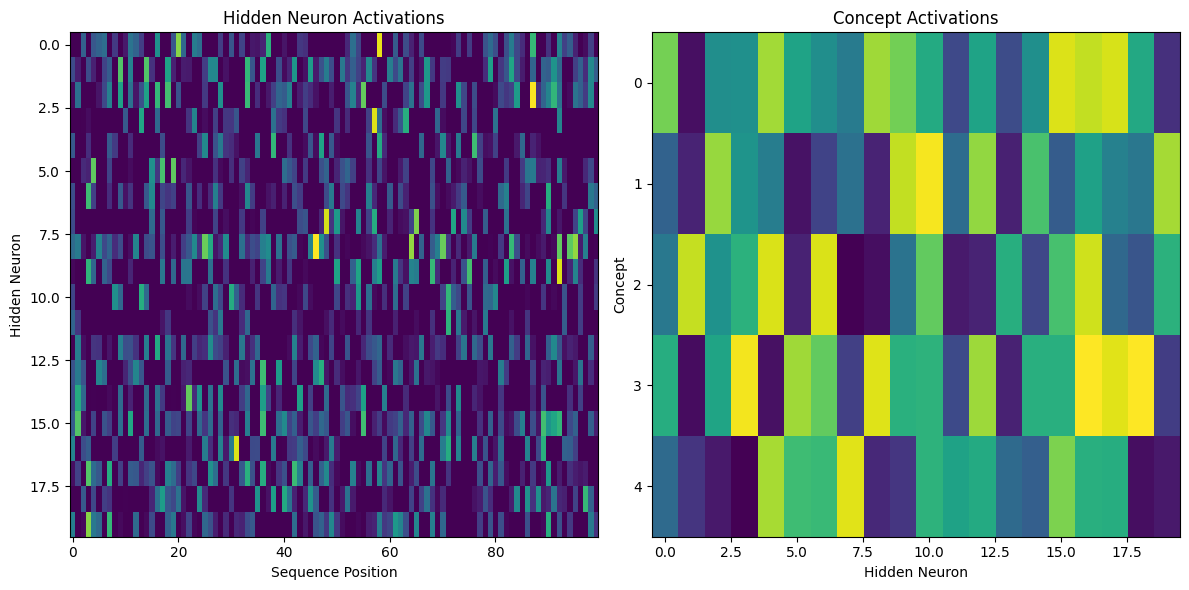

Correlation Matrix:
tensor([[ 1.0000,  0.2627, -0.0627,  0.0544,  0.1577, -0.2853],
        [ 0.2627,  1.0000,  0.0604, -0.0051,  0.5944,  0.3043],
        [-0.0627,  0.0604,  1.0000,  0.0394,  0.1046, -0.1701],
        [ 0.0544, -0.0051,  0.0394,  1.0000, -0.2142,  0.0359],
        [ 0.1577,  0.5944,  0.1046, -0.2142,  1.0000, -0.1420],
        [-0.2853,  0.3043, -0.1701,  0.0359, -0.1420,  1.0000]])


In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Define a simple language model
class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.relu(self.linear(x))
        return self.output(x)

# Parameters
vocab_size = 1000
embedding_dim = 50
hidden_dim = 20
num_concepts = 5

# Create model
model = SimpleLanguageModel(vocab_size, embedding_dim, hidden_dim)

# Generate random input
input_ids = torch.randint(0, vocab_size, (100,))

# Get hidden layer activations
with torch.no_grad():
    embeddings = model.embedding(input_ids)
    hidden_activations = torch.relu(model.linear(embeddings))

# Simulate concept activations
concept_activations = torch.rand((num_concepts, hidden_dim))

# Visualize superposition
plt.figure(figsize=(12, 6))

# Plot hidden neuron activations
plt.subplot(1, 2, 1)
plt.imshow(hidden_activations.T, aspect='auto', cmap='viridis')
plt.title('Hidden Neuron Activations')
plt.xlabel('Sequence Position')
plt.ylabel('Hidden Neuron')

# Plot concept activations
plt.subplot(1, 2, 2)
plt.imshow(concept_activations, aspect='auto', cmap='viridis')
plt.title('Concept Activations')
plt.xlabel('Hidden Neuron')
plt.ylabel('Concept')

plt.tight_layout()
plt.show()

# Print correlation matrix
correlation_matrix = torch.corrcoef(torch.cat([hidden_activations.mean(dim=0).unsqueeze(0), concept_activations]))
print("Correlation Matrix:")
print(correlation_matrix)

### Interpretation

In these visualizations, we see multiple concepts encoded in the same set of neurons.

In the first (left) subplot, we a heatmap of activations for each hidden neuron in the input sequence.

* Each row represents a single neuron in the hidden layer
* Each column represents a position in the input sequence
* The color intensity indicates the activation strength of each neuron at each position, with brighter colors showing higher activation

In the second, *concept activations* visualization, we see a heatmap showing activation patterns for different *concepts* across the hidden neurons.

* Rows represent different concepts
* Columns represent neurons in the hidden layer
* Color intensity indicates how strongly each concept is associated with each hidden neuron
* Brighter colors indicate stronger activations

### The key idea

These two visualizations overlap in hidden neuron space, so the same set of neurons are encoding *both* sequence and concept information simultaneously. That these two aspects coexist in the same hidden layer demonstrates superposition.

Using device: cuda


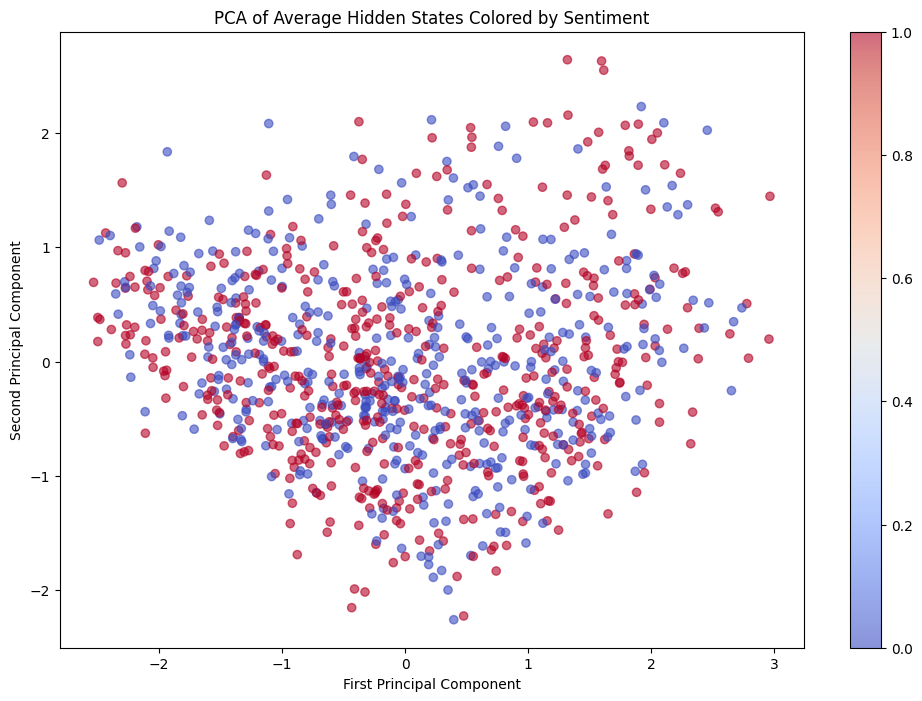

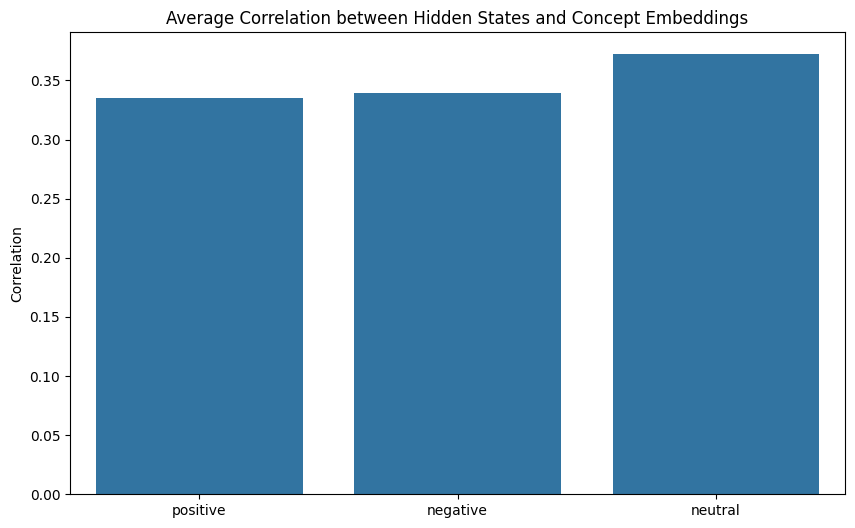

Correlations: {'positive': 0.33541225356469684, 'negative': 0.3389937145819827, 'neutral': 0.37208967616205857}


In [4]:
import torch
import torch.nn as nn
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name).to(device)

# Load a subset of the GLUE dataset (SST-2 for sentiment analysis)
dataset = load_dataset("glue", "sst2", split="train[:1000]")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")

tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)
tokenized_dataset.set_format("torch")

# Define linguistic concepts (simple version)
concepts = {
    "positive": ["good", "great", "excellent", "wonderful", "fantastic"],
    "negative": ["bad", "terrible", "awful", "horrible", "poor"],
    "neutral": ["okay", "fine", "average", "mediocre", "so-so"]
}

# Function to get hidden states
def get_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.cpu().numpy()

# Get hidden states for the dataset
hidden_states = []
for i in range(0, len(tokenized_dataset), 32):
    batch = tokenized_dataset[i:i+32]
    hidden_states.append(get_hidden_states(batch))

hidden_states = np.concatenate(hidden_states, axis=0)

# Calculate average hidden state for each input
avg_hidden_states = np.mean(hidden_states, axis=1)

# Perform PCA
pca = PCA(n_components=2)
reduced_states = pca.fit_transform(avg_hidden_states)

# Visualize the reduced hidden states
plt.figure(figsize=(12, 8))
scatter = plt.scatter(reduced_states[:, 0], reduced_states[:, 1], c=dataset["label"], cmap="coolwarm", alpha=0.6)
plt.colorbar(scatter)
plt.title("PCA of Average Hidden States Colored by Sentiment")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.show()

# Function to get concept embeddings
def get_concept_embeddings(concepts):
    concept_embeddings = {}
    for concept, words in concepts.items():
        embeddings = []
        for word in words:
            inputs = tokenizer(word, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model(**inputs)
            embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().numpy())
        concept_embeddings[concept] = np.mean(embeddings, axis=0).flatten()
    return concept_embeddings

concept_embeddings = get_concept_embeddings(concepts)

# Calculate correlation between average hidden states and concept embeddings
correlations = {}
for concept, embedding in concept_embeddings.items():
    corr = np.mean([np.corrcoef(avg_state, embedding)[0, 1] for avg_state in avg_hidden_states])
    correlations[concept] = corr

# Visualize correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=list(correlations.keys()), y=list(correlations.values()))
plt.title("Average Correlation between Hidden States and Concept Embeddings")
plt.ylabel("Correlation")
plt.show()

print("Correlations:", correlations)

### Interpretation

In the PCA plot, we see clusters of points with different colors, suggesting the model is distinguishing between different sentiments in its hidden representations.

In the correlation bar plot, the higher values suggest hidden states are more tightly correlated with that particular concept. The high correlations for multiple concepts suggests the model is encoding multiple concepts simultaneously in its hidden states.